# Large Scale Data Science (CC3047) - 2024/2025

## Machine Learning Pipeline - Is solving this problem an actual challenge?

Work by Alexandre Sousa (2022206427) and Francisco Carqueija (202205113)

---

The project focuses on building a Machine Learning pipeline that aims to perform large-scale data analysis on patient events in the ICU. The main focuses of this work are:

-> Statistical analysis and visualization of data by patient (SUBJECT_ID)

-> Prediction of length of stay in the ICU with machine learning models.

-> Use appropriate tools to efficiently process large volumes of data (PySpark, MapReduce, BigQuery, etc.).

-> Evaluate and discuss performance issues (execution time, profile).

For this project we need to take into consideration the choices for our preprocessing, the choices for our data preparation, our choices on how to train and validate our models and the quality of the analysis, interpretations and discussion of results

---

## Table of contents

<!-- Hello World -->
1. [Libraries Needed](#Libraries-Needed)
2. [Introduction](#Introduction)
    - [ADMISSIONS](#ADMISSIONS)
    - [CHARTEVENTS](#CHARTEVENTS)
    - [D_ITEMS](#D_ITEMS)
    - [DIAGNOSES_ICD](#DIAGNOSES_ICD)
    - [D_ICD_DIAGNOSES](#D_ICD_DIAGNOSES)
    - [ICUSTAYS](#ICUSTAYS)
    - [PATIENTS](#PATIENTS)
    - [PROCEDURES_ICD](#PROCEDURES_ICD)
    - [D_ICD_PROCEDURES](#D_ICD_PROCEDURES)
3. [Data Preparation](#Data-Preparation)
4. [Training and Validation](#Training-and-Validation)
5. [Data Analysis](#Data-Analysis)
6. [Conclusions](#Conclusion)
7. [References](#References)



---

## Libraries Needed 

In [95]:
!python -V

Python 3.11.11


In [1]:
import os
from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ml-pipeline-459822-e0958fb6a5e7.json"

client = bigquery.Client()

In [2]:
import bigframes as bf
import bigframes.pandas as bpd

In [3]:
import pandas as pd
import dask.dataframe as dd

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, mean as count, when, udf, regexp_replace, coalesce, lit
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

In [6]:
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns

---

## Introduction
[[ go back to the top ]](#Table-of-contents)




### NEED TO CHANGE !!!!!!!!!

The dataset we are analysing is CHARTEVENTS.csv.gz from the MIMIC-III clinical database. 
It contains detailed time-stamped measurements and observations recorded in the ICU, including vital signs (e.g., heart rate, blood pressure, temperature), lab test results, and other patient-specific metrics. Each row corresponds to a single charted event and includes key fields such as SUBJECT_ID (patient identifier), HADM_ID (hospital admission ID), ICUSTAY_ID (ICU stay ID), ITEMID (type of measurement), CHARTTIME (timestamp), and VALUE (the observed or recorded value). The dataset is large and granular, enabling detailed temporal analysis of patient states during ICU stays, which is essential for tasks like predicting length of stay, assessing patient deterioration, and analyzing treatment outcomes.

### -Why we use bigframes.pandasand not other tools

We use bigframes.pandas because it lets us work with massive BigQuery datasets using familiar pandas-like syntax, without downloading the data. All operations run in BigQuery, making it scalable and memory-efficient — ideal for analyzing MIMIC’s large medical tables.

##### Why Not Other Tools
- pandas: Loads all data into memory — crashes with large datasets.
- cuDF: Needs a local GPU, not suited for cloud SQL queries.
- Dask/Polars: Good for local or distributed CSVs, but don’t integrate easily with BigQuery.

---

## ADMISSIONS
[[ go back to the top ]](#Table-of-contents)


In [102]:
df_admissions = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.admissions`", use_cache=False)

In [103]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,14629,11898,108389,2128-01-13 20:55:00+00:00,2128-01-15 18:20:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,DISCH-TRAN TO PSYCH HOSP,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2128-01-13 18:08:00+00:00,2128-01-13 22:36:00+00:00,OVERDOSE,0,1
1,14339,11705,165730,2165-11-18 13:40:00+00:00,2165-11-27 17:30:00+00:00,<NA>,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,<NA>,NOT SPECIFIED,<NA>,OTHER,<NA>,<NA>,NEWBORN,0,1
2,57944,96731,198001,2124-09-11 17:37:00+00:00,2124-09-13 14:38:00+00:00,<NA>,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,2124-09-11 09:32:00+00:00,2124-09-11 19:17:00+00:00,ASTHMA;CHRONIC OBST PULM DISEASE,0,1
3,55611,89600,108570,2106-03-17 11:44:00+00:00,2106-03-20 12:50:00+00:00,2106-03-20 12:50:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,2106-03-17 10:01:00+00:00,2106-03-17 14:19:00+00:00,ACUTE SUBDURAL HEMATOMA,1,1
4,31247,25553,164133,2146-05-30 20:47:00+00:00,2146-06-22 23:59:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN,2146-05-30 19:02:00+00:00,2146-05-30 21:35:00+00:00,COPD EXACERBATION,0,1


In [104]:
df_admissions.shape

(58976, 19)

---

## CHARTEVENTS
[[ go back to the top ]](#Table-of-contents)


In [105]:
df_chartevents=bpd.read_gbq("ml-pipeline-459822.data.chartevents", use_cache=False)

In [106]:
df_chartevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,227480130,1663,162078,295174,8551,2141-04-06 07:50:00,2141-04-06 07:52:00,15004,160,160.0,mmHg,<NA>,<NA>,<NA>,NotStopd
1,35461753,234,134944,233735,776,2106-04-10 12:38:00,2106-04-10 12:42:00,15331,-3,-3.0,<NA>,<NA>,<NA>,Final,NotStopd
2,36434629,423,194013,248770,1484,2169-07-07 02:30:00,2169-07-07 04:25:00,18524,Yes,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
3,213123811,19361,128434,276021,392,2177-02-03 04:00:00,2177-02-03 04:19:00,17704,Serous,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
4,145067178,21838,143088,200378,3446,2136-08-14 08:00:00,2136-08-14 08:12:00,19371,33-36 weeks gest,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd


In [107]:
df_chartevents.shape

(330712483, 15)

De todas as colunas desta tabela, as colunas que não são precisas e podem ser descartadas, são:

STORETIME -> since it records the time at which an observation was manually input or manually validadted, it is not relevant dor the context of the lenght of the stay of a patient
CGID -> not relevant to know who validated the given measurement
ERROR -> Como os dados com erro nas medidas tiradas não servem para prever ou correlacionar com outros dados, pois estão erradas, esta coluna não nos faz falta. Todas as linhas com erro = 0 já aqui estão.
RESTULSTATUS, STOPPED -> Também não são precisos, pois não são relevantes para o problema em questão.

In [108]:
df_chartevents = df_chartevents.drop(columns=["STORETIME", "CGID"])

---

## D_ITEMS
[[ go back to the top ]](#Table-of-contents)


In [109]:
df_d_items = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_items`", use_cache=False)

In [110]:
df_d_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,3325,1996,HIGH MIN. VOL.,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
1,4423,6898,TRACHEA DSG,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
2,12841,223921,Neuro Symptoms,Neuro Symptoms,metavision,chartevents,Neurological,<NA>,Text,<NA>
3,1655,4813,nutrition labs,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
4,556,599,RUL Lung Sounds,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>


Podemos eliminar a coluna ABBREVIATION

Desta tabela não queremos eliminar alguma coluna ainda, para efeitos de análise exploratória por paciente.

In [111]:
df_d_items.shape

(12487, 10)

---

## DIAGNOSES_ICD
[[ go back to the top ]](#Table-of-contents)


In [112]:
df_diagnoses_icd = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.diagnoses_icd`", use_cache=False)

In [113]:
df_diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,328395,28879,163707,5,4019
1,607827,90609,146682,1,0380
2,577044,83314,108439,2,5070
3,564547,80752,180665,21,42789
4,591003,86662,140257,19,2724


In [114]:
df_diagnoses_icd.shape

(651047, 5)

---

## D_ICD_DIAGNOSES
[[ go back to the top ]](#Table-of-contents)


In [115]:
df_d_icd_diagnoses = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_icd_diagnoses`", use_cache=False)

In [116]:
df_d_icd_diagnoses.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,14184,E9839,Undet circ-suffocate NOS,Strangulation or suffocation by unspecified me...
1,11678,E9258,Electric current acc NEC,Accident caused by other electric current
2,8999,7810,Abn involun movement NEC,Abnormal involuntary movements
3,7735,6959,Erythematous cond NOS,Unspecified erythematous condition
4,399,0913,Secondary syph skin,Secondary syphilis of skin or mucous membranes


In [117]:
df_d_icd_diagnoses.shape

(14567, 4)

---

## ICUSTAYS
[[ go back to the top ]](#Table-of-contents)


In [118]:
df_icustays = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.icustays`", use_cache=False)

In [119]:
df_icustays.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,53549,76114,127379,238616,metavision,TSICU,TSICU,14,14,2194-04-28 18:25:13+00:00,2194-04-29 16:01:00+00:00,0.8998
1,53711,76502,197100,298669,metavision,TSICU,TSICU,14,14,2142-11-04 10:29:02+00:00,2142-11-05 13:43:13+00:00,1.1348
2,36549,28843,194297,234364,carevue,TSICU,TSICU,14,14,2156-07-30 20:16:36+00:00,2156-07-31 19:48:40+00:00,0.9806
3,19054,15021,102989,278373,carevue,CSRU,CSRU,14,14,2181-04-05 11:08:06+00:00,2181-04-06 22:46:33+00:00,1.485
4,26492,20892,182895,210457,carevue,NICU,NICU,56,56,2143-05-29 18:41:52+00:00,2143-05-30 13:29:11+00:00,0.7829


In [120]:
df_icustays.shape

(61532, 12)

---

## PATIENTS
[[ go back to the top ]](#Table-of-contents)

In [121]:
df_patients = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.patients`", use_cache=False)

In [122]:
df_patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,33888,51786,F,2090-04-16 00:00:00+00:00,<NA>,<NA>,<NA>,0
1,23653,25061,M,2114-07-11 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,1
2,44113,90788,M,2094-04-24 00:00:00+00:00,<NA>,<NA>,<NA>,0
3,3452,3652,F,2042-07-26 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,1
4,10760,11381,M,2143-04-22 00:00:00+00:00,<NA>,<NA>,<NA>,0


In [123]:
df_patients.shape

(46520, 8)

---

## PROCEDURES_ICD
[[ go back to the top ]](#Table-of-contents)


In [124]:
df_procedures_icd = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.procedures_icd`", use_cache=False)

In [125]:
df_procedures_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,66403,25809,117092,5,9604
1,13101,2237,142708,2,3606
2,23025,1563,183430,4,9672
3,198865,53463,183511,7,9711
4,201551,99544,145236,15,7966


In [126]:
df_procedures_icd.shape

(240095, 5)

---

## D_ICD_PROCEDURES
[[ go back to the top ]](#Table-of-contents)

In [127]:
df_d_icd_procedures = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_icd_procedures`", use_cache=False)

In [128]:
df_d_icd_procedures.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,1100,2169,Turbinectomy NEC,Other turbinectomy
1,796,3887,Occlude abd vein NEC,"Other surgical occlusion of vessels, abdominal..."
2,2056,8423,Forearm/wrist/hand reatt,"Forearm, wrist, or hand reattachment"
3,723,3857,Abd varicos v liga-strip,"Ligation and stripping of varicose veins, abdo..."
4,3178,9461,Alcohol rehabilitation,Alcohol rehabilitation


In [129]:
df_d_icd_procedures.shape

(3882, 4)

---

## Obtain the top 3 diseases with more occurencies
In this section, we investigate which disease occurs most frequently in the dataset.

In [130]:
# Step 1: Get top 3 ICD9 codes by frequency
top_5_codes = df_diagnoses_icd['ICD9_CODE'].value_counts().head(5).index

print("Top 5 most common disease codes:")
# Step 2: Loop through the top codes and retrieve their SHORT_TITLE
for code in top_5_codes:
    # Filter for the corresponding row in d_icd_diagnoses
    filtered_row = df_d_icd_diagnoses[df_d_icd_diagnoses['ICD9_CODE'] == code]
    
    if not filtered_row.empty:
        short_title = filtered_row['SHORT_TITLE'].values[0]
        count = df_diagnoses_icd['ICD9_CODE'].value_counts()[code]
        print(f"{short_title} ({code}) — {count} occurrences")
    else:
        print(f"ICD9 code {code} not found in the descriptions table.")

Top 5 most common disease codes:
Hypertension NOS (4019) — 20703 occurrences
CHF NOS (4280) — 13111 occurrences
Atrial fibrillation (42731) — 12891 occurrences
Crnry athrscl natve vssl (41401) — 12429 occurrences
Acute kidney failure NOS (5849) — 9119 occurrences


---

# Merge dos datasets

Depois da análise de cada um dos datasets, vamos juntar todos os datasets com duas querys. 
Primeiro, vamos juntar todos os datasets conforme as ID key. 
Depois, juntar a tabela das doenças e filtrar com as 5 doenças mais comuns.

In [131]:
query = """
SELECT DISTINCT
  chartevents.SUBJECT_ID,
  chartevents.HADM_ID,
  chartevents.ICUSTAY_ID,
  patients.DOB,
  admissions.ADMITTIME,
  admissions.DISCHTIME,
  admissions.DEATHTIME,
  admissions.HOSPITAL_EXPIRE_FLAG,
  admissions.ADMISSION_TYPE,
  patients.GENDER,
  admissions.ETHNICITY,
  admissions.RELIGION,
  admissions.LANGUAGE,
  admissions.MARITAL_STATUS,
  admissions.INSURANCE,
  chartevents.ITEMID,
  d_items.LABEL,
  chartevents.VALUE,
  chartevents.VALUENUM,
  chartevents.WARNING,
  chartevents.ERROR,
  d_items.DBSOURCE,
  icustays.LOS
FROM
  `ml-pipeline-459822.data.chartevents` AS chartevents
LEFT JOIN
  `ml-pipeline-459822.data.patients` AS patients
  ON chartevents.SUBJECT_ID = patients.SUBJECT_ID
LEFT JOIN
  `ml-pipeline-459822.data.d_items` AS d_items
  ON chartevents.ITEMID = d_items.ITEMID
LEFT JOIN
  `ml-pipeline-459822.data.admissions` AS admissions
  ON chartevents.HADM_ID = admissions.HADM_ID
LEFT JOIN
  `ml-pipeline-459822.data.icustays` AS icustays
  ON chartevents.ICUSTAY_ID = icustays.ICUSTAY_ID
"""
# Executing the SQL query and storing the results in the 'all_features' dataframe
all_features = bpd.read_gbq(query, use_cache=False)

# Displaying the resulting dataframe
all_features

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,MARITAL_STATUS,INSURANCE,ITEMID,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS
0,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
1,19128,157773,208389,2038-10-02 00:00:00+00:00,2114-05-17 17:49:00+00:00,2114-05-28 13:10:00+00:00,<NA>,0,EMERGENCY,F,...,MARRIED,Medicare,39,Airway Size,7.0 mm,<NA>,<NA>,<NA>,carevue,3.2075
2,4064,135867,225146,2093-05-06 00:00:00+00:00,2139-08-28 19:23:00+00:00,2139-10-06 20:19:00+00:00,<NA>,0,EMERGENCY,M,...,MARRIED,Medicare,456,NBP Mean,99,99.0,<NA>,<NA>,carevue,35.0882
3,91343,131485,272660,2073-04-06 00:00:00+00:00,2159-01-09 21:16:00+00:00,2159-01-25 03:34:00+00:00,2159-01-25 03:34:00+00:00,1,ELECTIVE,M,...,MARRIED,Medicare,224089,Anti Embolic Device,None,<NA>,0,0,metavision,15.3172
4,83180,196309,206237,2127-09-19 00:00:00+00:00,2187-12-28 16:31:00+00:00,2188-01-16 17:30:00+00:00,<NA>,0,EMERGENCY,F,...,SINGLE,Private,223989,LLL Lung Sounds,Crackles,<NA>,0,0,metavision,4.0219
5,74793,181257,241021,2059-12-23 00:00:00+00:00,2136-03-20 08:00:00+00:00,2136-03-24 14:00:00+00:00,<NA>,0,ELECTIVE,M,...,WIDOWED,Medicare,220052,Arterial Blood Pressure mean,66,66.0,0,0,metavision,1.2985
6,51413,146604,282515,2028-08-22 00:00:00+00:00,2114-07-29 01:33:00+00:00,2114-08-02 16:56:00+00:00,<NA>,0,EMERGENCY,F,...,SINGLE,Medicare,223916,Response to Stimuli (Type),Verbal,<NA>,0,0,metavision,1.7007
7,73039,188272,256867,2089-01-27 00:00:00+00:00,2151-10-11 16:20:00+00:00,2151-10-30 16:00:00+00:00,<NA>,0,EMERGENCY,F,...,SINGLE,Private,220051,Arterial Blood Pressure diastolic,65,65.0,0,0,metavision,6.8374
8,1853,119890,232342,2143-04-29 00:00:00+00:00,2166-04-07 12:00:00+00:00,2166-04-12 13:02:00+00:00,<NA>,0,EMERGENCY,M,...,SINGLE,Private,1522,Calcium,7.9000000953674316,7.9,<NA>,<NA>,carevue,2.4754
9,63992,149191,204344,2113-06-07 00:00:00+00:00,2169-05-15 16:03:00+00:00,2169-06-15 17:40:00+00:00,<NA>,0,EMERGENCY,M,...,SINGLE,Medicaid,224665,PCA total dose,7.44,7.44,0,0,metavision,6.4819


In [132]:
# Writing the 'all_features' dataframe to the 'cdl-pratica.Data.all_features' table in Google BigQuery, replacing it if it already exists
all_features.to_gbq('ml-pipeline-459822.data.all_features', if_exists='replace')

'ml-pipeline-459822.data.all_features'

In [133]:
# SQL query to select all features from the 'all_features' table and additional diagnosis-related columns from the 'df_diagnoses' table,
# joining them on the 'SUBJECT_ID' column and filtering rows where the 'ICD9_CODE' column equals '4019'
query2 = """
SELECT DISTINCT
  af.*,
  d.ICD9_CODE,
  d.SEQ_NUM
FROM
  `ml-pipeline-459822.data.all_features` AS af
LEFT JOIN
  `ml-pipeline-459822.data.diagnoses_icd` AS d
ON
  af.SUBJECT_ID = d.SUBJECT_ID AND af.HADM_ID = d.HADM_ID
WHERE
  d.ICD9_CODE IN ('4019', '42731', '4280', '41401', '5849')
"""

# Executing the SQL query and storing the results in the 'raw_features' dataframe
raw_features = bpd.read_gbq(query2, use_cache=False)

# Displaying the resulting dataframe
raw_features

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,ITEMID,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SEQ_NUM
0,11446,165408,238331,2146-04-03 00:00:00+00:00,2203-08-07 20:01:00+00:00,2203-08-13 18:00:00+00:00,<NA>,0,EMERGENCY,F,...,455,NBP [Systolic],97,97.0,<NA>,<NA>,carevue,2.8834,5849,3
1,44514,195301,283993,2100-03-18 00:00:00+00:00,2159-04-23 07:46:00+00:00,2159-04-27 22:10:00+00:00,2159-04-27 22:10:00+00:00,1,EMERGENCY,F,...,227066,Cerebral Perfusion Pressure,92,92.0,0,0,metavision,4.6655,4019,9
2,4803,159789,250946,1872-07-09 00:00:00+00:00,2172-07-09 17:28:00+00:00,2172-07-15 21:33:00+00:00,2172-07-15 21:33:00+00:00,1,EMERGENCY,M,...,455,NBP [Systolic],83,83.0,<NA>,<NA>,carevue,6.1694,4019,6
3,138,188284,254974,2083-10-23 00:00:00+00:00,2133-12-21 23:52:00+00:00,2134-01-11 13:00:00+00:00,<NA>,0,EMERGENCY,M,...,421,LCW,10.81659984588623,10.8166,<NA>,<NA>,carevue,3.9687,4280,3
4,3235,175562,220995,2077-03-08 00:00:00+00:00,2143-01-02 19:23:00+00:00,2143-01-19 20:43:00+00:00,2143-01-19 20:43:00+00:00,1,EMERGENCY,F,...,430,LVSW,33.456001281738281,33.456001,<NA>,<NA>,carevue,17.0545,4280,2
5,27965,171782,295509,1823-08-10 00:00:00+00:00,2123-08-10 20:38:00+00:00,2123-08-11 05:23:00+00:00,2123-08-11 05:23:00+00:00,1,EMERGENCY,F,...,184,Eye Opening,3 To speech,3.0,<NA>,<NA>,carevue,0.3427,4280,4
6,21280,199369,229375,2114-08-15 00:00:00+00:00,2164-02-13 22:35:00+00:00,2164-02-16 12:00:00+00:00,2164-02-16 12:00:00+00:00,1,EMERGENCY,M,...,619,Respiratory Rate Set,24,24.0,<NA>,<NA>,carevue,3.0867,41401,8
7,12540,195743,290504,2127-04-05 00:00:00+00:00,2194-09-15 20:24:00+00:00,2194-10-23 17:08:00+00:00,<NA>,0,EMERGENCY,M,...,227465,Prothrombin time,16.2,16.2,1,0,metavision,26.9452,41401,35
8,93093,148359,243256,2133-06-18 00:00:00+00:00,2195-11-03 16:50:00+00:00,2195-11-09 16:35:00+00:00,<NA>,0,EMERGENCY,M,...,226104,Level of Consciousness,Arouse to Pain,<NA>,0,0,metavision,3.0991,4280,1
9,28412,121643,239223,2078-06-22 00:00:00+00:00,2162-11-09 00:58:00+00:00,2162-11-16 14:20:00+00:00,<NA>,0,EMERGENCY,F,...,224,IABP Mean,105,105.0,<NA>,<NA>,carevue,4.5173,41401,4


In [134]:

# Writing the 'raw_features' dataframe to the 'cdl-pratica.Data.raw_features' table in Google BigQuery, replacing it if it already exists
raw_features.to_gbq('ml-pipeline-459822.data.raw_features', if_exists='replace')
     

'ml-pipeline-459822.data.raw_features'

------

## **Data Pre-Processing**

Agora vamos pré processar os dados de forma a garantir a sua qualidade 

In [135]:
# Reading data from the 'cdl-pratica.Data.raw_features' table in Google BigQuery and storing it in the 'raw_features' dataframe
raw_features = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

# Displaying the resulting dataframe
raw_features

/Users/alexandresousa/Desktop/Projeto Big Data/.conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3667: UserWarning: Reading cached table from 2025-05-29 14:04:37.104332+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/alexandresousa/Desktop/Projeto Big Data/.conda/lib/python3.11/site-packages/bigframes/session/_io/bigquery/read_gbq_table.py:160: TimeTravelDisabledWarning: NotFound error when reading table with time travel. Attempting query
without time travel. Warning: Without time travel, modifications to
the underlying table may result in errors or unexpected behavior.
  warnings.warn(msg, category=bfe.TimeTravelDisabledWarning)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,ITEMID,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SEQ_NUM
0,11446,165408,238331,2146-04-03 00:00:00+00:00,2203-08-07 20:01:00+00:00,2203-08-13 18:00:00+00:00,<NA>,0,EMERGENCY,F,...,455,NBP [Systolic],97,97.0,<NA>,<NA>,carevue,2.8834,5849,3
1,44514,195301,283993,2100-03-18 00:00:00+00:00,2159-04-23 07:46:00+00:00,2159-04-27 22:10:00+00:00,2159-04-27 22:10:00+00:00,1,EMERGENCY,F,...,227066,Cerebral Perfusion Pressure,92,92.0,0,0,metavision,4.6655,4019,9
2,4803,159789,250946,1872-07-09 00:00:00+00:00,2172-07-09 17:28:00+00:00,2172-07-15 21:33:00+00:00,2172-07-15 21:33:00+00:00,1,EMERGENCY,M,...,455,NBP [Systolic],83,83.0,<NA>,<NA>,carevue,6.1694,4019,6
3,138,188284,254974,2083-10-23 00:00:00+00:00,2133-12-21 23:52:00+00:00,2134-01-11 13:00:00+00:00,<NA>,0,EMERGENCY,M,...,421,LCW,10.81659984588623,10.8166,<NA>,<NA>,carevue,3.9687,4280,3
4,3235,175562,220995,2077-03-08 00:00:00+00:00,2143-01-02 19:23:00+00:00,2143-01-19 20:43:00+00:00,2143-01-19 20:43:00+00:00,1,EMERGENCY,F,...,430,LVSW,33.456001281738281,33.456001,<NA>,<NA>,carevue,17.0545,4280,2
5,27965,171782,295509,1823-08-10 00:00:00+00:00,2123-08-10 20:38:00+00:00,2123-08-11 05:23:00+00:00,2123-08-11 05:23:00+00:00,1,EMERGENCY,F,...,184,Eye Opening,3 To speech,3.0,<NA>,<NA>,carevue,0.3427,4280,4
6,21280,199369,229375,2114-08-15 00:00:00+00:00,2164-02-13 22:35:00+00:00,2164-02-16 12:00:00+00:00,2164-02-16 12:00:00+00:00,1,EMERGENCY,M,...,619,Respiratory Rate Set,24,24.0,<NA>,<NA>,carevue,3.0867,41401,8
7,12540,195743,290504,2127-04-05 00:00:00+00:00,2194-09-15 20:24:00+00:00,2194-10-23 17:08:00+00:00,<NA>,0,EMERGENCY,M,...,227465,Prothrombin time,16.2,16.2,1,0,metavision,26.9452,41401,35
8,93093,148359,243256,2133-06-18 00:00:00+00:00,2195-11-03 16:50:00+00:00,2195-11-09 16:35:00+00:00,<NA>,0,EMERGENCY,M,...,226104,Level of Consciousness,Arouse to Pain,<NA>,0,0,metavision,3.0991,4280,1
9,28412,121643,239223,2078-06-22 00:00:00+00:00,2162-11-09 00:58:00+00:00,2162-11-16 14:20:00+00:00,<NA>,0,EMERGENCY,F,...,224,IABP Mean,105,105.0,<NA>,<NA>,carevue,4.5173,41401,4


**Valores Nulos**

In [136]:


# Verificar a quantidade de valores nulos por coluna
missing_values = raw_features.isnull().sum()

# Calcular a porcentagem de valores nulos por coluna
missing_percentage = (missing_values / len(raw_features)) * 100

# Combinar as informações em um DataFrame para melhor visualização
missing_data = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentagem (%)': missing_percentage,
    'Tipo de Dado': raw_features.dtypes
})

# Exibir as colunas com valores nulos
missing_data = missing_data[missing_data['Valores Nulos'] > 0]
print(missing_data.sort_values(by='Porcentagem (%)', ascending=False))

                Valores Nulos  Porcentagem (%)                    Tipo de Dado
DEATHTIME            53623388        82.900675  timestamp[us, tz=UTC][pyarrow]
WARNING              37828032        58.481374                           Int64
ERROR                37828032        58.481374                           Int64
LANGUAGE             23130042        35.758578                 string[pyarrow]
VALUENUM             19579557        30.269600                         Float64
MARITAL_STATUS        2662910         4.116805                 string[pyarrow]
VALUE                 1657774         2.562885                 string[pyarrow]
RELIGION               463903         0.717185                 string[pyarrow]
ICUSTAY_ID              69389         0.107274                           Int64
LOS                     69389         0.107274                         Float64


Aqui está uma estimativa aproximada da percentagem de valores em falta para algumas colunas:

DEATHTIME: ~94%

LANGUAGE: ~35%

RELIGION: ~0.44%

MARITAL_STATUS: ~3.2%

VALUENUM: ~61%

WARNING / ERROR: ~66%

LOS: ~0.08%

Existem algumas colunas onde o número de valores nulo é relativamente alto então não têm uma utilidade no processo de análise e exploração de resultados acerca dos pacientes. Portanto podemos retirar essas colunas

In [137]:
# Supondo que o teu DataFrame se chama raw_features
filtered_features = raw_features.drop(columns=['DEATHTIME', 'VALUENUM', 'WARNING', 'ERROR'])

Preencher valores nulos com 'Unknown' pode ser útil para evitar erros em análises subsequentes, especialmente ao trabalhar com modelos que não aceitam valores nulos.

In [138]:
# Filling missing values in the 'LANGUAGE' column with 'UNKNOWN'
filtered_features['LANGUAGE'] = filtered_features['LANGUAGE'].fillna('UNKNOWN')

# Filling missing values in the 'MARITAL_STATUS' column with 'UNKNOWN'
filtered_features['MARITAL_STATUS'] = filtered_features['MARITAL_STATUS'].fillna('UNKNOWN')

# Filling missing values in the 'RELIGION' column with 'UNKNOWN'
filtered_features['RELIGION'] = filtered_features['RELIGION'].fillna('UNKNOWN')

**Linhas Repetidas**

In [139]:
# Ver todas as linhas exatamente duplicadas (todas as colunas iguais)
duplicadas = raw_features[raw_features.duplicated()]

# Mostrar quantas há
print(f"Número de linhas duplicadas: {duplicadas.shape[0]}")

Número de linhas duplicadas: 0


Não existem linhas repetidas


In [1]:
# Writing the 'filtered_features' dataframe to the 'cdl-pratica.Data.filtered_features' table in Google BigQuery, replacing it if it already exists
filtered_features.to_gbq('ml-pipeline-459822.data.filtered_features', if_exists='replace')

NameError: name 'filtered_features' is not defined

## Análise Exploratória De Cada Paciente

In [9]:
# Reading data from the 'cdl-pratica.Data.raw_features' table in Google BigQuery and storing it in the 'raw_features' dataframe
raw_features = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

Primeiro de estudo, para conseguirmos fazer uma análise estatística e exploratório por pacientes, devemos agrupar os dados por 'SUBJECT_ID'. 

Esse bloco de código faz uma agregação por paciente (SUBJECT_ID) para calcular estatísticas clínicas resumidas, produzindo um novo DataFrame chamado pacientes, onde cada linha representa um paciente e as colunas representam informações agregadas sobre as suas admissões e estadias na UCI.

In [ ]:
# Agrupar por paciente (SUBJECT_ID)
pacientes = raw_features.groupby('SUBJECT_ID').agg({
    'HADM_ID': 'nunique',  # nº de admissões
    'ICUSTAY_ID': 'nunique',  # nº de estadias em UCI
    'LOS': 'mean',  # duração média de estadia na UCI
    'VALUENUM': 'mean',  # média dos valores registados (ex: sinais vitais)
    'HOSPITAL_EXPIRE_FLAG': 'max'  # se morreu em alguma admissão
}).reset_index().rename(columns={
    'HADM_ID': 'num_admissoes',
    'ICUSTAY_ID': 'num_ucis',
    'LOS': 'media_los',
    'VALUENUM': 'media_valores',
    'HOSPITAL_EXPIRE_FLAG': 'faleceu'
})


Número de Pacientes no DataSet com as 5 doenças mais comuns: 

In [11]:
num_pacientes = raw_features['SUBJECT_ID'].nunique()
print(f"Número total de pacientes únicos: {num_pacientes}")

Número total de pacientes únicos: 28472


**Número de Admissões Por Paciente**

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/4167237436.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=admissoes_count, x='num_admissoes', y='num_pacientes', palette='Blues_d')


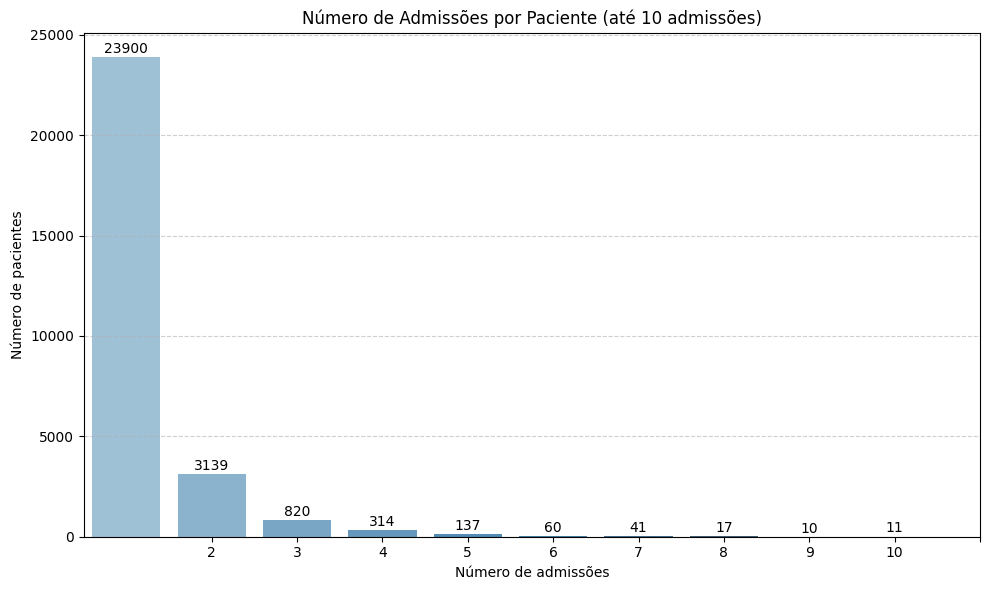

In [25]:
query = """
SELECT
  SUBJECT_ID,
  COUNT(DISTINCT HADM_ID) AS num_admissoes
FROM
  `ml-pipeline-459822.data.raw_features`
GROUP BY
  SUBJECT_ID
"""

num_admissoes = bpd.read_gbq(query).to_pandas()


# Contar número de pacientes por número de admissões
# Correção robusta com nomes explícitos
admissoes_count = num_admissoes['num_admissoes'].value_counts().sort_index()
admissoes_count = admissoes_count.reset_index()
admissoes_count.columns = ['num_admissoes', 'num_pacientes']

# Limitar aos 10 primeiros valores para melhor leitura
admissoes_count = admissoes_count[admissoes_count['num_admissoes'] <= 10]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=admissoes_count, x='num_admissoes', y='num_pacientes', palette='Blues_d')

# Adicionar rótulos nas barras
for index, row in admissoes_count.iterrows():
    plt.text(index, row['num_pacientes'] + 50, int(row['num_pacientes']), ha='center', va='bottom')

plt.title("Número de Admissões por Paciente (até 10 admissões)")
plt.xlabel("Número de admissões")
plt.ylabel("Número de pacientes")
plt.xticks(range(1, 11))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/3010145359.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pacientes_por_tipo, x='ADMISSION_TYPE', y='num_pacientes', palette='Set2')


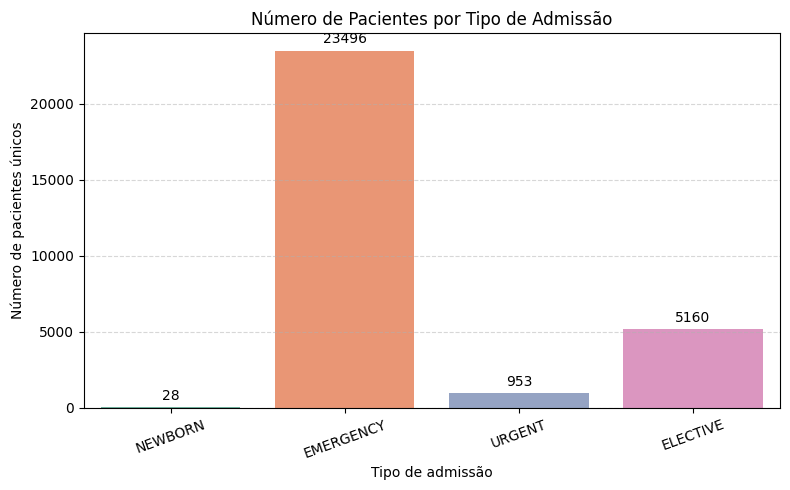

In [26]:
 # Executar a query
query = """
SELECT
  ADMISSION_TYPE,
  COUNT(DISTINCT SUBJECT_ID) AS num_pacientes
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  num_pacientes DESC
"""
pacientes_por_tipo = bpd.read_gbq(query).to_pandas()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=pacientes_por_tipo, x='ADMISSION_TYPE', y='num_pacientes', palette='Set2')

# Adicionar valores nas barras
for index, row in pacientes_por_tipo.iterrows():
    plt.text(index, row['num_pacientes'] + 500, int(row['num_pacientes']), ha='center')

plt.title("Número de Pacientes por Tipo de Admissão")
plt.xlabel("Tipo de admissão")
plt.ylabel("Número de pacientes únicos")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Número dos Tipos de Admissões

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/156803317.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tipos_admissao, x='ADMISSION_TYPE', y='num_admissoes', palette='Purples_d')


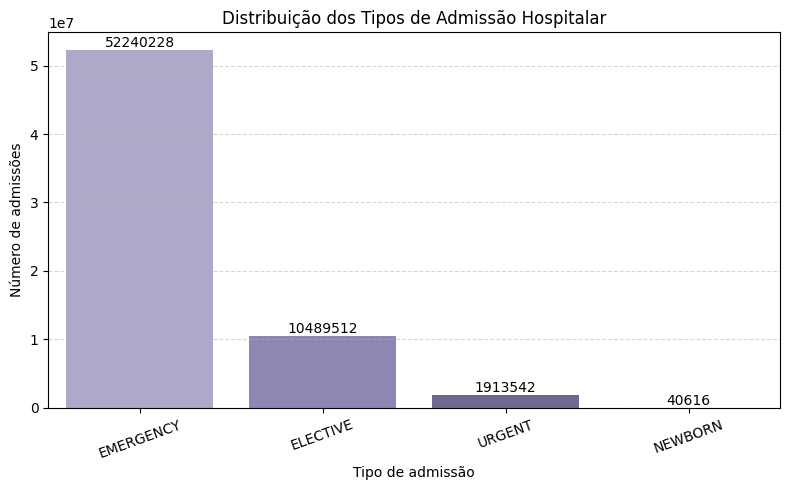

In [23]:
query="""
SELECT DISTINCT
  ADMISSION_TYPE,
  COUNT(*) AS num_admissoes
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  num_admissoes DESC
"""

# Lê os dados da query
tipos_admissao = bpd.read_gbq(query).to_pandas()


plt.figure(figsize=(8, 5))
sns.barplot(data=tipos_admissao, x='ADMISSION_TYPE', y='num_admissoes', palette='Purples_d')

# Adicionar contagens
for index, row in tipos_admissao.iterrows():
    plt.text(index, row['num_admissoes'] + 1000, int(row['num_admissoes']), ha='center', va='bottom')

plt.title("Distribuição dos Tipos de Admissão Hospitalar")
plt.xlabel("Tipo de admissão")
plt.ylabel("Número de admissões")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Mortalidade Por Tipo de Admissão: 


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/3062485731.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mortalidade_admissao, x='ADMISSION_TYPE', y='taxa_mortalidade_pct', palette='Reds')


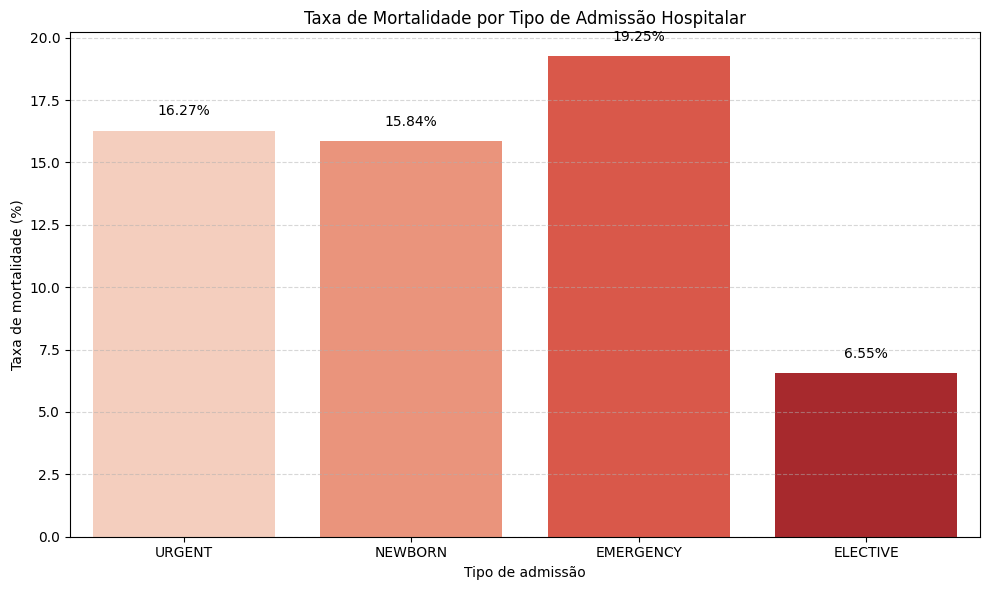

In [14]:
query="""
SELECT
  ADMISSION_TYPE,
  COUNT(*) AS num_admissoes,
  SUM(HOSPITAL_EXPIRE_FLAG) AS num_obitos,
  ROUND(SUM(HOSPITAL_EXPIRE_FLAG) / COUNT(*) * 100, 2) AS taxa_mortalidade_pct
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  num_admissoes DESC
"""

mortalidade_admissao = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=mortalidade_admissao, x='ADMISSION_TYPE', y='taxa_mortalidade_pct', palette='Reds')

for index, row in mortalidade_admissao.iterrows():
    plt.text(index, row['taxa_mortalidade_pct'] + 0.5, f"{row['taxa_mortalidade_pct']}%", 
             ha='center', va='bottom')

plt.title("Taxa de Mortalidade por Tipo de Admissão Hospitalar")
plt.ylabel("Taxa de mortalidade (%)")
plt.xlabel("Tipo de admissão")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/3257659301.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=los_admissao, x='ADMISSION_TYPE', y='media_los_dias', palette='Blues')


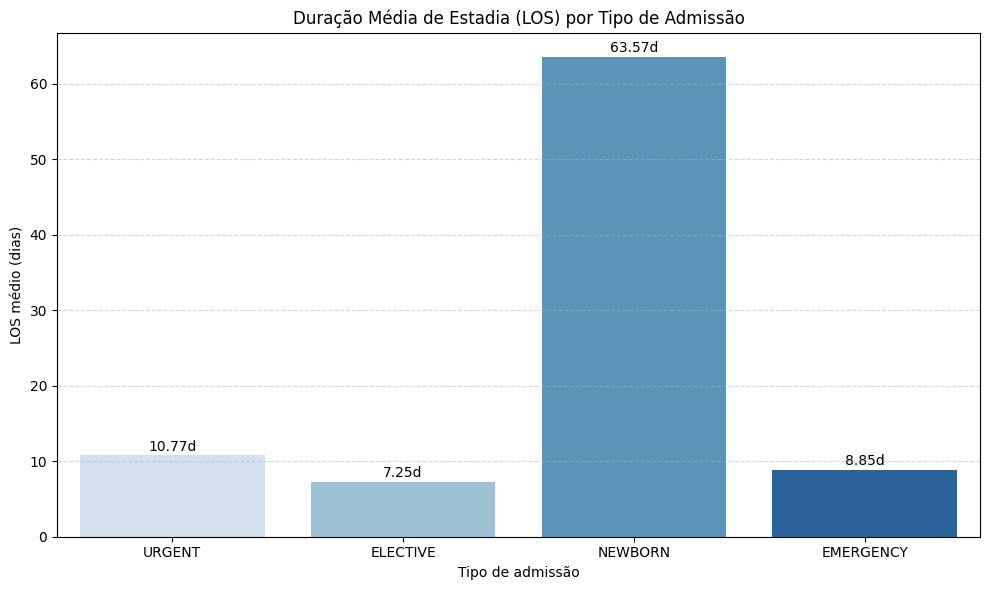

In [15]:
query="""
SELECT
  ADMISSION_TYPE,
  ROUND(AVG(LOS), 2) AS media_los_dias
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL AND LOS IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  media_los_dias DESC
"""

los_admissao = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=los_admissao, x='ADMISSION_TYPE', y='media_los_dias', palette='Blues')

for index, row in los_admissao.iterrows():
    plt.text(index, row['media_los_dias'] + 0.2, f"{row['media_los_dias']}d", 
             ha='center', va='bottom')

plt.title("Duração Média de Estadia (LOS) por Tipo de Admissão")
plt.ylabel("LOS médio (dias)")
plt.xlabel("Tipo de admissão")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/1745098633.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=estadias_count, x='num_estadias_uci', y='num_pacientes', palette='Greens_d')


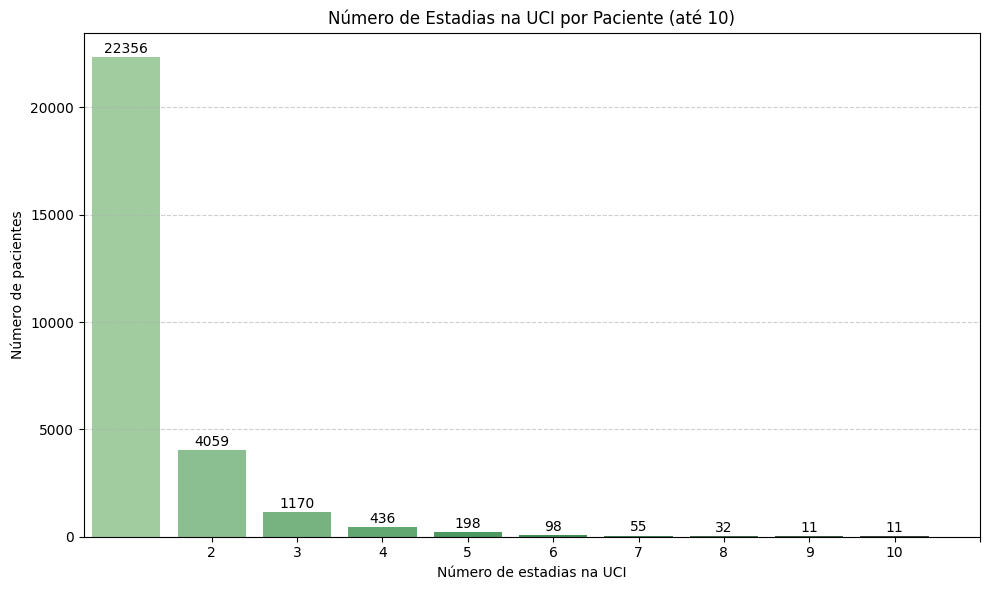

In [10]:
# Query para contar número de estadias em UCI por paciente
query_icu = """
SELECT
  SUBJECT_ID,
  COUNT(DISTINCT ICUSTAY_ID) AS num_estadias_uci
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ICUSTAY_ID IS NOT NULL
GROUP BY
  SUBJECT_ID
"""

num_estadias = bpd.read_gbq(query_icu).to_pandas()

# Contar número de pacientes por número de estadias
estadias_count = num_estadias['num_estadias_uci'].value_counts().sort_index()
estadias_count = estadias_count.reset_index()
estadias_count.columns = ['num_estadias_uci', 'num_pacientes']

# Limitar a 10 para visualização
estadias_count = estadias_count[estadias_count['num_estadias_uci'] <= 10]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=estadias_count, x='num_estadias_uci', y='num_pacientes', palette='Greens_d')

for index, row in estadias_count.iterrows():
    plt.text(index, row['num_pacientes'] + 50, int(row['num_pacientes']), ha='center', va='bottom')

plt.title("Número de Estadias na UCI por Paciente (até 10)")
plt.xlabel("Número de estadias na UCI")
plt.ylabel("Número de pacientes")
plt.xticks(range(1, 11))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

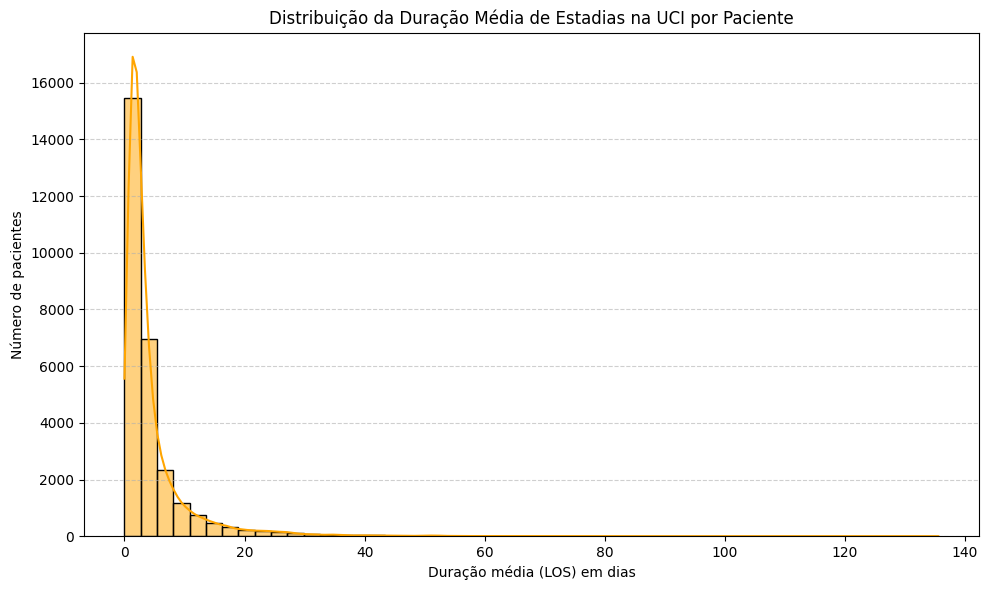

In [11]:
# Query para calcular o tempo médio de estadia (LOS) por paciente
query_los = """
SELECT
  SUBJECT_ID,
  AVG(LOS) AS media_los
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ICUSTAY_ID IS NOT NULL AND LOS IS NOT NULL
GROUP BY
  SUBJECT_ID
"""

media_los = bpd.read_gbq(query_los).to_pandas()

# Plot da distribuição da média de LOS
plt.figure(figsize=(10, 6))
sns.histplot(media_los['media_los'], bins=50, kde=True, color='orange')

plt.title("Distribuição da Duração Média de Estadias na UCI por Paciente")
plt.xlabel("Duração média (LOS) em dias")
plt.ylabel("Número de pacientes")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Medições Clínicas Mais Comuns (Label - D_ITEMS)

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/174409521.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_labels, y='LABEL', x='total_ocorrencias', palette='Blues_d')


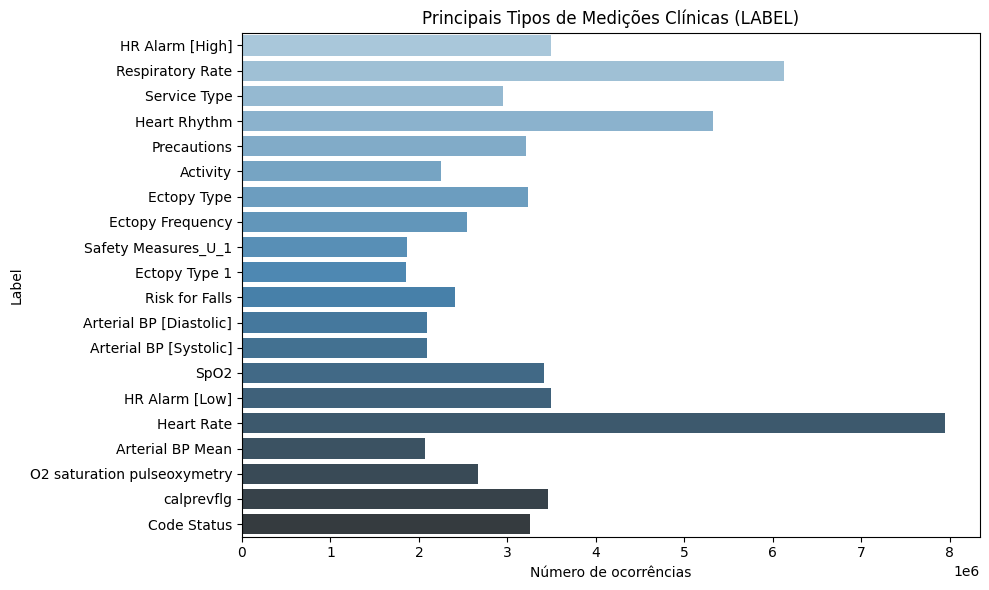

In [12]:
query = """
SELECT
  di.LABEL,
  COUNT(*) AS total_ocorrencias
FROM
  `ml-pipeline-459822.data.chartevents` AS ce
JOIN
  `ml-pipeline-459822.data.d_items` AS di
ON
  ce.ITEMID = di.ITEMID
GROUP BY
  di.LABEL
ORDER BY
  total_ocorrencias DESC
LIMIT 20
"""

top_labels = bpd.read_gbq(query).to_pandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_labels, y='LABEL', x='total_ocorrencias', palette='Blues_d')
plt.title("Principais Tipos de Medições Clínicas (LABEL)")
plt.xlabel("Número de ocorrências")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

# Género 


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/1971803897.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genero_dist, x='GENDER', y='num_pacientes', palette='pastel')


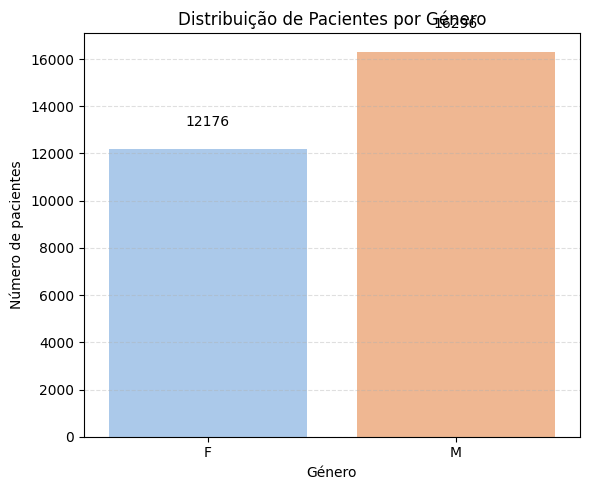

In [17]:
query="""
SELECT
  GENDER,
  COUNT(DISTINCT SUBJECT_ID) AS num_pacientes
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  GENDER IS NOT NULL
GROUP BY
  GENDER
"""

genero_dist = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(6, 5))
sns.barplot(data=genero_dist, x='GENDER', y='num_pacientes', palette='pastel')

for index, row in genero_dist.iterrows():
    plt.text(index, row['num_pacientes'] + 1000, int(row['num_pacientes']), ha='center')

plt.title("Distribuição de Pacientes por Género")
plt.xlabel("Género")
plt.ylabel("Número de pacientes")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Principais Diagnósticos Por Género**

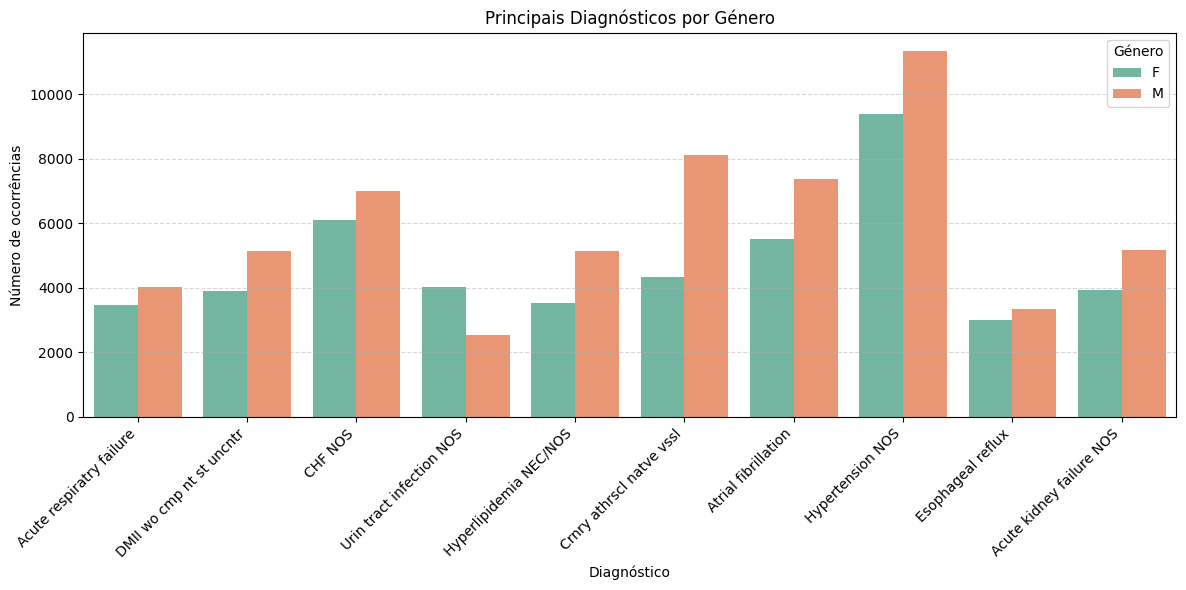

In [18]:
query="""
SELECT
  p.GENDER,
  dd.SHORT_TITLE AS diagnostico,
  COUNT(*) AS num_ocorrencias
FROM
  `ml-pipeline-459822.data.diagnoses_icd` AS d
JOIN
  `ml-pipeline-459822.data.d_icd_diagnoses` AS dd
ON
  d.ICD9_CODE = dd.ICD9_CODE
JOIN
  `ml-pipeline-459822.data.patients` AS p
ON
  d.SUBJECT_ID = p.SUBJECT_ID
WHERE
  p.GENDER IN ('M', 'F')
GROUP BY
  p.GENDER, dd.SHORT_TITLE
ORDER BY
  num_ocorrencias DESC
LIMIT 1000
"""

# Lê os dados da query
df = bpd.read_gbq(query).to_pandas()

# Filtra os 10 diagnósticos mais comuns por género
top_diagnosticos = (
    df.groupby('diagnostico')['num_ocorrencias'].sum()
    .nlargest(10)
    .index.tolist()
)

df_top = df[df['diagnostico'].isin(top_diagnosticos)]

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top, x='diagnostico', y='num_ocorrencias', hue='GENDER', palette='Set2')

plt.title("Principais Diagnósticos por Género")
plt.ylabel("Número de ocorrências")
plt.xlabel("Diagnóstico")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Género')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()